In [1]:
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report

import lightgbm as lgb

/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-

In [2]:
df_public = pd.read_csv('csv_data/archive/df_public_test_old.csv', index_col='Unnamed: 0')
df_private = pd.read_csv('csv_data/archive/df_private_test_old.csv', index_col='Unnamed: 0')

In [3]:
df_NR = pd.read_csv('csv_data/archive/df_NR_old.csv', index_col='Unnamed: 0')
df_ER = pd.read_csv('csv_data/archive/df_ER_old.csv', index_col='Unnamed: 0')
df = pd.concat([df_NR, df_ER])

In [4]:
df.query('event_energy == 6 and event_class == "ER"')

,N_error_x,N_error_y,N_x,N_y,bkgr_count_x,bkgr_count_y,chi2_pvalue_x,chi2_pvalue_y,chi2_x,chi2_y,...,sig_density_x,sig_density_y,sigma_error_x,sigma_error_y,sigma_x,sigma_y,tolerance_x,tolerance_y,up_x,up_y
2950,1204.317146,1204.363644,1.450380e+06,1.450492e+06,1.445151e+06,1.446360e+06,0.262632,1.0,124.206241,12.223563,...,931.339372,912.771956,0.857808,0.742359,5.614171,4.526541,0.1,0.1,1.0,1.0


In [5]:
df.head()

,N_error_x,N_error_y,N_x,N_y,bkgr_count_x,bkgr_count_y,chi2_pvalue_x,chi2_pvalue_y,chi2_x,chi2_y,...,sig_density_x,sig_density_y,sigma_error_x,sigma_error_y,sigma_x,sigma_y,tolerance_x,tolerance_y,up_x,up_y
0,1206.637565,1206.681719,1.455974e+06,1.456081e+06,1.444396e+06,1.444421e+06,0.361109,1.0,119.791687,13.214974,...,1901.642411,1957.030110,0.411301,0.382048,6.088278,5.957908,0.1,0.1,1.0,1.0
1,1207.664738,1207.710921,1.458454e+06,1.458566e+06,1.447905e+06,1.447484e+06,0.229623,1.0,125.887962,14.307645,...,1798.402254,1760.160929,0.365382,0.447666,5.865764,6.295820,0.1,0.1,1.0,1.0
2,1207.247486,1207.285299,1.457446e+06,1.457538e+06,1.446820e+06,1.446684e+06,0.677506,1.0,107.511003,16.191973,...,1936.867548,1842.717275,0.389578,0.400726,5.486320,5.889989,0.1,0.1,1.0,1.0
3,1205.990627,1206.021705,1.454413e+06,1.454488e+06,1.445649e+06,1.445507e+06,0.973091,1.0,87.612217,12.662547,...,1559.555571,1513.261980,0.487056,0.495516,5.619956,5.935238,0.1,0.1,1.0,1.0
4,1206.420576,1206.473541,1.455451e+06,1.455578e+06,1.445947e+06,1.445930e+06,0.042415,1.0,142.396549,14.601006,...,1653.311634,1604.499565,0.405450,0.485708,5.748477,6.013079,0.1,0.1,1.0,1.0


In [6]:
# feat_list = ['N_error_x', 'N_error_y', 'N_x', 'N_y', 'bkgr_count_x', 'bkgr_count_y',
#        'chi2_pvalue_x', 'chi2_pvalue_y', 'chi2_x', 'chi2_y', 'dfr', 'dmu',
#        'dsigma', 'edm_x', 'edm_y', 'event_ID', 'event_angle', 'event_class',
#        'event_energy', 'fr_error_x', 'fr_error_y', 'fr_x', 'fr_y', 'fval_x',
#        'fval_y', 'has_accurate_covar_x', 'has_accurate_covar_y',
#        'has_covariance_x', 'has_covariance_y', 'has_made_posdef_covar_x',
#        'has_made_posdef_covar_y',
#        'has_posdef_covar_x', 'has_posdef_covar_y',
#        'has_reached_call_limit_x', 'has_reached_call_limit_y',
#        'hesse_failed_x', 'hesse_failed_y', 'image_name',
#         'is_valid_x', 'is_valid_y', 'mu_error_x',
#        'mu_error_y', 'mu_x', 'mu_y', 'n_excess_bins_x', 'n_excess_bins_y',
#        'nfcn_total_x', 'nfcn_total_y', 'nfcn_x', 'nfcn_y', 'ngrad_total_x',
#        'ngrad_total_y', 'ngrad_x', 'ngrad_y', 'sig_count_x', 'sig_count_y',
#        'sig_density_x', 'sig_density_y', 'sigma_error_x', 'sigma_error_y',
#        'sigma_x', 'sigma_y',]

In [7]:
# df = df[feat_list]

In [8]:
df['sig_count_x_over_E'] = df['sig_count_x'] / df['event_energy']
df['sig_count_y_over_E'] = df['sig_count_y'] / df['event_energy']
# df['dsig_count'] = df['sig_count_x'] - df['sig_count_y']
# df_public['dsig_count'] = df_public['sig_count_x'] - df_public['sig_count_y']
# df_private['dsig_count'] = df_private['sig_count_x'] - df_private['sig_count_y']

### boxplots

In [8]:
cut = 'sig_count_x > 0 and sig_count_x < 1.e5 and sig_count_y > 0 and sig_count_y < 1.e5'
# cut += ' and event_energy < 30 and event_energy > 1'  
cut += ' and fr_x > 1.e-5 and fr_y > 1.e-5 and sigma_x < 10 and sigma_y < 10'
# cut += ' and chi2_pvalue_y > 0.05 and dmu < 1'

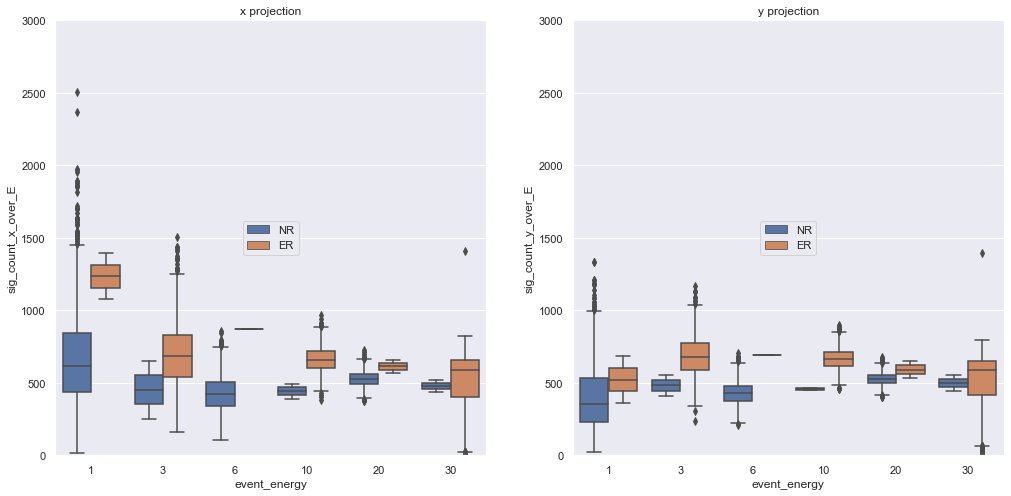

In [9]:
f, axes = plt.subplots(1, 2, figsize=(17,8))
for ax, proj in zip(axes, ['x', 'y']):
    ax.set_ylim(0, 3000)
    ax.set_title(f'{proj} projection')
    g = sns.boxplot(x='event_energy', y=f'sig_count_{proj}_over_E', hue='event_class', data=df.query(cut), ax=ax)
    g.legend(loc='center')

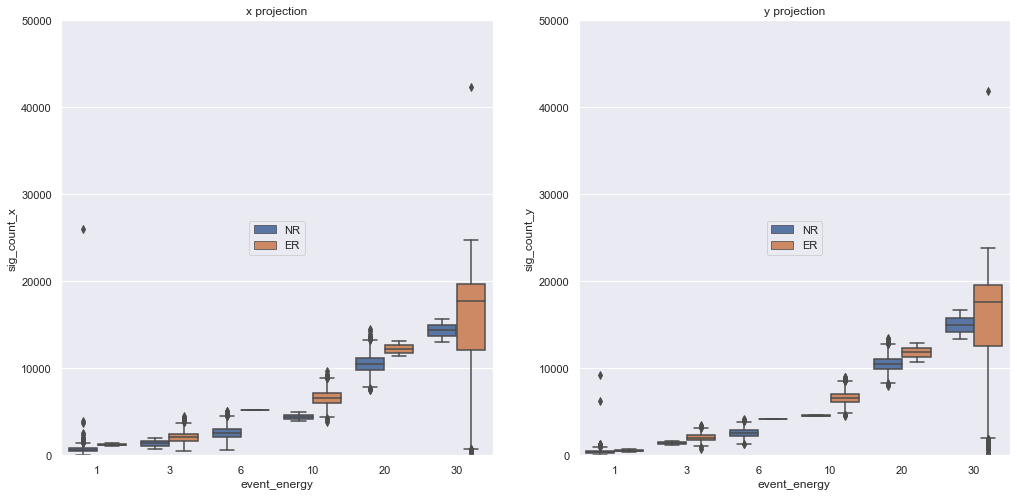

In [10]:
f, axes = plt.subplots(1, 2, figsize=(17,8))
for ax, proj in zip(axes, ['x', 'y']):
    ax.set_ylim(0, 50000)
    ax.set_title(f'{proj} projection')
    g = sns.boxplot(x='event_energy', y=f'sig_count_{proj}', hue='event_class', data=df.query(cut), ax=ax)
    g.legend(loc='center')

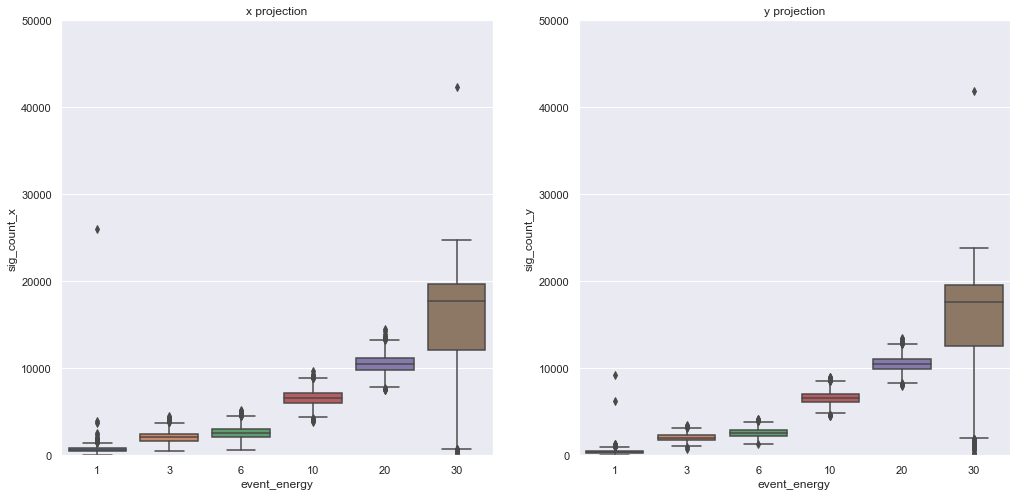

In [11]:
f, axes = plt.subplots(1, 2, figsize=(17,8))
for ax, proj in zip(axes, ['x', 'y']):
    ax.set_ylim(0, 50000)
    ax.set_title(f'{proj} projection')
    g = sns.boxplot(x='event_energy', y=f'sig_count_{proj}', data=df.query(cut), ax=ax)

### dev

In [12]:
cut

'sig_count_x > 0 and sig_count_x < 1.e5 and sig_count_y > 0 and sig_count_y < 1.e5 and fr_x > 1.e-5 and fr_y > 1.e-5 and sigma_x < 10 and sigma_y < 10'

In [13]:
bw_adjust = 0.3

Dataset has 0 variance; skipping density estimate.


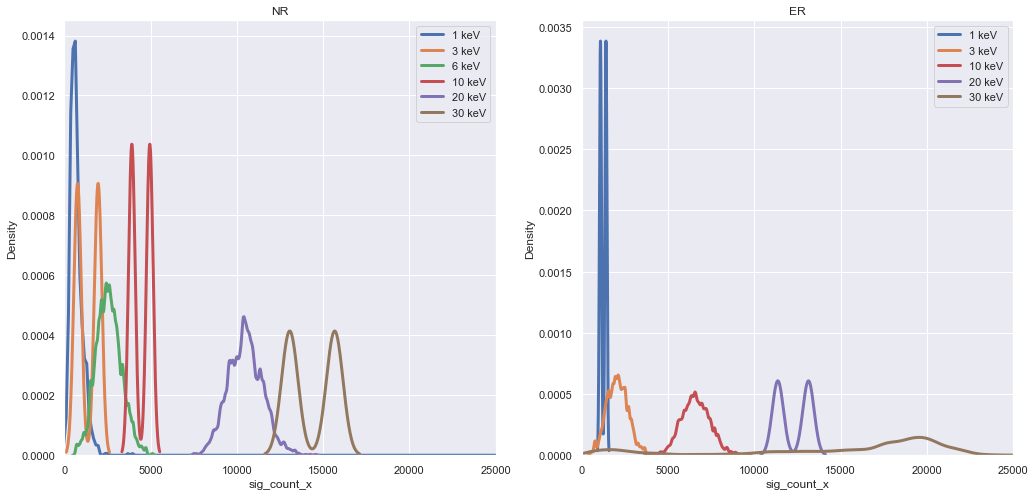

In [14]:
f, axes = plt.subplots(1, 2, figsize=(17,8))
for ax, ec in zip(axes, ['NR', 'ER']):
    ax.set_title(ec)
    ax.set_xlim(0, 25000)
    sns.kdeplot(df.query(cut + ' and event_energy == 1' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='1 keV')
    sns.kdeplot(df.query(cut + ' and event_energy == 3' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='3 keV')
    sns.kdeplot(df.query(cut + ' and event_energy == 6' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='6 keV')
    sns.kdeplot(df.query(cut + ' and event_energy == 10' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='10 keV')
    sns.kdeplot(df.query(cut + ' and event_energy == 20' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='20 keV')
    sns.kdeplot(df.query(cut + ' and event_energy == 30' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='30 keV')
    ax.legend()
plt.show()

Dataset has 0 variance; skipping density estimate.


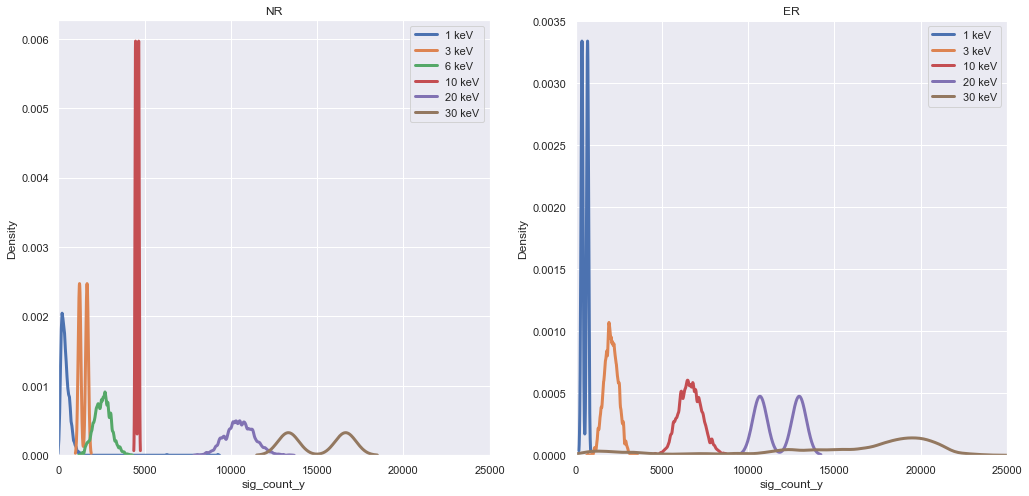

In [15]:
f, axes = plt.subplots(1, 2, figsize=(17,8))
for ax, ec in zip(axes, ['NR', 'ER']):
    ax.set_title(ec)
    ax.set_xlim(0, 25000)
    sns.kdeplot(df.query(cut + ' and event_energy == 1' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='1 keV')
    sns.kdeplot(df.query(cut + ' and event_energy == 3' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='3 keV')
    sns.kdeplot(df.query(cut + ' and event_energy == 6' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='6 keV')
    sns.kdeplot(df.query(cut + ' and event_energy == 10' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='10 keV')
    sns.kdeplot(df.query(cut + ' and event_energy == 20' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='20 keV')
    sns.kdeplot(df.query(cut + ' and event_energy == 30' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='30 keV')
    ax.legend()
plt.show()

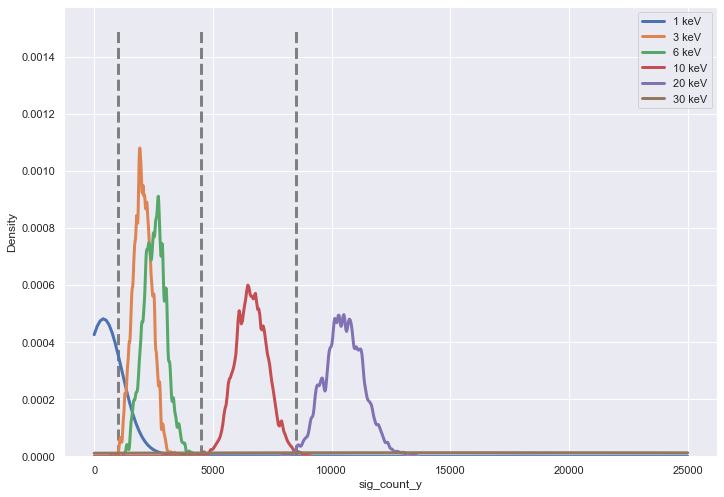

In [16]:
sns.kdeplot(df.query('event_energy == 1').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='1 keV')
sns.kdeplot(df.query('event_energy == 3').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='3 keV')
sns.kdeplot(df.query('event_energy == 6').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='6 keV')
sns.kdeplot(df.query('event_energy == 10').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='10 keV')
sns.kdeplot(df.query('event_energy == 20').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='20 keV')
sns.kdeplot(df.query('event_energy == 30').sig_count_y, bw_adjust=2*bw_adjust, clip=(0, 25000), linewidth=3, label='30 keV')
plt.vlines([1000, 4500, 8500], 0, 0.0015, 'grey', linestyles='dashed', linewidth=3)
plt.legend()
plt.show()

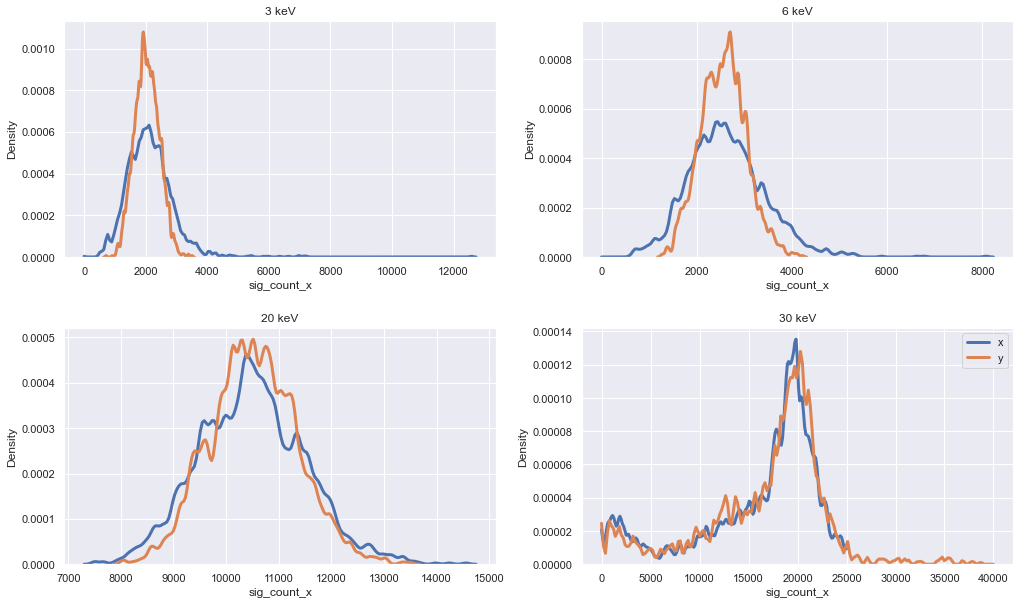

In [17]:
f, axes = plt.subplots(2, 2, figsize=(17,10))
f.subplots_adjust(hspace=0.3)
sns.kdeplot(df.query('event_energy == 3').sig_count_x, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='x', ax=axes[0,0]); axes[0,0].set_title('3 keV'); 
sns.kdeplot(df.query('event_energy == 3').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='y', ax=axes[0,0])
sns.kdeplot(df.query('event_energy == 6').sig_count_x, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='x', ax=axes[0,1]); axes[0,1].set_title('6 keV')
sns.kdeplot(df.query('event_energy == 6').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='y', ax=axes[0,1])
sns.kdeplot(df.query('event_energy == 20').sig_count_x, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='x', ax=axes[1,0]); axes[1,0].set_title('20 keV')
sns.kdeplot(df.query('event_energy == 20').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='y', ax=axes[1,0])
sns.kdeplot(df.query('event_energy == 30').sig_count_x, bw_adjust=0.01*bw_adjust, clip=(0, 25000), linewidth=3, label='x', ax=axes[1,1]); axes[1,1].set_title('30 keV')
sns.kdeplot(df.query('event_energy == 30').sig_count_y, bw_adjust=0.01*bw_adjust, clip=(0, 40000), linewidth=3, label='y', ax=axes[1,1])
plt.legend()
plt.show()

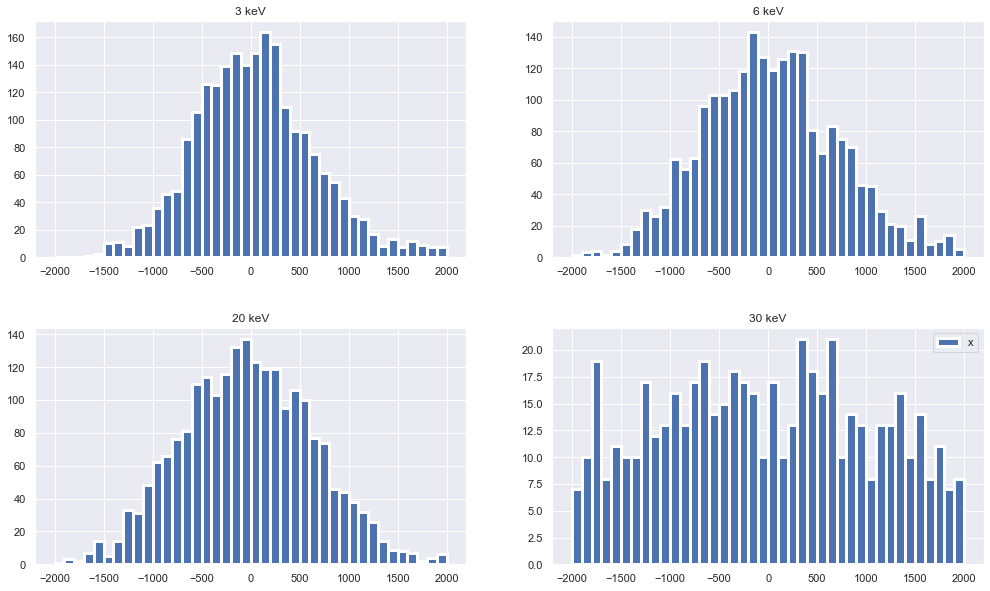

In [18]:
f, axes = plt.subplots(2, 2, figsize=(17,10))
f.subplots_adjust(hspace=0.3)
axes[0,0].hist(df.query('event_energy == 3').sig_count_x - df.query('event_energy == 3').sig_count_y, linewidth=3, label='x', bins=40, range=(-2000, 2000)); axes[0,0].set_title('3 keV'); 
axes[0,1].hist(df.query('event_energy == 6').sig_count_x - df.query('event_energy == 6').sig_count_y, linewidth=3, label='x', bins=40, range=(-2000, 2000)); axes[0,1].set_title('6 keV')
axes[1,0].hist(df.query('event_energy == 20').sig_count_x - df.query('event_energy == 20').sig_count_y, linewidth=3, label='x', bins=40, range=(-2000, 2000)); axes[1,0].set_title('20 keV')
axes[1,1].hist(df.query('event_energy == 30').sig_count_x - df.query('event_energy == 30').sig_count_y, linewidth=3, label='x', bins=40, range=(-2000, 2000)); axes[1,1].set_title('30 keV')
plt.legend()
plt.show()

* wiggly
* nothing
* normal gauss
* *ER 10 keV

### importanto

На графике выше при селективном подходе, мысль о котором возникла в чате (комбинация ... vs all + каты), я забыл про разные домены в трейне и тесте. Методика будет работать, если есть тождественность между ER<->NR по распределениям энергии. Это не так для энергии в 30 кэВ, где при замене ER<->NR качественно меняется поведение частицы данной энергии + аналогично для энергии 20 кэВ (но мб вероятность отлёта электрона становится меньше и события становятся чуть больше похожи на NR). Для энергии в 1кэВ я бы ожидал инвариантности (что там, что там ничего не видно среди плоского фона). В промежуточных энергиях есть ощущение, что пики и форма инвариантны при замене типа события, мб с небольшим сдвигом положения (см выше графики sig_count/E (E)). Мб попробовать вслепую потюнить пороги катов относительно трейновских и посмотреть как меняется скор на паблике

Итого, можно попробовать вот так (перебираются классы событий, ожидаемые в тесте): 
* 30 NR: детектить катом по sig_count, каким-то образом оценив положение пика и форму из 30 ER (например, взяв те 2.5 сэмпла из трейна или же глазами разметив парочку ярких событий в паблике😏)
* 20 ER: детектить через классификатор wiggly vs all. Можно потренить на 30 ER, выбрав фичи инвариантные к энергии (e.g. p-value фита)
* 10 NR: детектить катом по sig_count (см картинку серые линии). Здесь предполагаем инвариантость формы при ER<->NR замене (то есть что пик не съедет и не станет шире) - надо чекать
* 3 NR, 6 ER: хз, они перекрываются по энергии, поэтому мб натренить классификатор 3 vs 6 (тоже предположив инвариантность при замене доменов ER<->NR)
* 1 ER: хз, мб катом тоже порезать, или натренить классификатор "ничего не видно vs что-то видно"

### searching for wiggly

In [19]:
np.unique(df.event_energy, return_counts=True)

(array([ 1,  3,  6, 10, 20, 30]), array([2179, 2245, 2256, 2274, 2210, 2239]))

In [20]:
df.columns

Index(['N_error_x', 'N_error_y', 'N_x', 'N_y', 'bkgr_count_x', 'bkgr_count_y',
       'chi2_pvalue_x', 'chi2_pvalue_y', 'chi2_x', 'chi2_y', 'dfr', 'dmu',
       'dsigma', 'edm_x', 'edm_y', 'event_ID', 'event_angle', 'event_class',
       'event_energy', 'fr_error_x', 'fr_error_y', 'fr_x', 'fr_y', 'fval_x',
       'fval_y', 'has_accurate_covar_x', 'has_accurate_covar_y',
       'has_covariance_x', 'has_covariance_y', 'has_made_posdef_covar_x',
       'has_made_posdef_covar_y', 'has_parameters_at_limit_x',
       'has_parameters_at_limit_y', 'has_posdef_covar_x', 'has_posdef_covar_y',
       'has_reached_call_limit_x', 'has_reached_call_limit_y',
       'has_valid_parameters_x', 'has_valid_parameters_y', 'hesse_failed_x',
       'hesse_failed_y', 'image_name', 'is_above_max_edm_x',
       'is_above_max_edm_y', 'is_valid_x', 'is_valid_y', 'mu_error_x',
       'mu_error_y', 'mu_x', 'mu_y', 'n_excess_bins_x', 'n_excess_bins_y',
       'nfcn_total_x', 'nfcn_total_y', 'nfcn_x', 'nfcn_y', 'ngr

In [21]:
wiggly_vars = [
              'chi2_pvalue_x', 'chi2_pvalue_y', 
#                'chi2_x', 'chi2_y',
              'dfr', 
              'dmu', 'dsigma', 
              'sigma_x', 'sigma_y', 
#                'sigma_error_x', 'sigma_error_y', 
              'mu_x', 'mu_y', 
#                'mu_error_x', 'mu_error_y', 
       'n_excess_bins_x', 'n_excess_bins_y', 
#                'nfcn_total_x', 'nfcn_total_y',
#        'nfcn_x', 'nfcn_y', 'ngrad_total_x', 'ngrad_total_y', 'ngrad_x', 'ngrad_y', 
#                'sig_count_x', 'sig_count_y', 
#        'sig_density_x', 'sig_density_y', 
#                'dsig_count'
              ]

In [22]:
df_1 = df[df['event_energy'] == 1][:500]
df_3 = df[df['event_energy'] == 3][:500]
df_6 = df[df['event_energy'] == 6][:500]
df_10 = df[df['event_energy'] == 10][:500]
df_20 = df[df['event_energy'] == 20][:500]
df_30 = df[df['event_energy'] == 30]
df_w_vs_all = pd.concat([df_1,df_3,df_6,df_10,df_20,df_30])

In [23]:
# df_w_vs_all['sig_count_y_gr_8500'] = df_w_vs_all.sig_count_y > 8500
# df_public['sig_count_y_gr_8500'] = df_public.sig_count_y > 8500
# df_private['sig_count_y_gr_8500'] = df_private.sig_count_y > 8500

In [24]:
np.unique(df_w_vs_all.event_energy, return_counts=1)

(array([ 1,  3,  6, 10, 20, 30]), array([ 500,  500,  500,  500,  500, 2239]))

In [25]:
X = df_w_vs_all[wiggly_vars]
y = df_w_vs_all['event_energy'] == 30
np.bincount(y)

array([2500, 2239])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [28]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'early_stopping_rounds': 10
}

In [29]:
gbm = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                verbose_eval=True,
#                 feature_name=X_train.columns,
#                 categorical_feature=[21]
               )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.612991
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.548824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_logloss: 0.495788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_logloss: 0.452686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_logloss: 0.413558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_logloss: 0.377661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's b

Found `early_stopping_rounds` in params. Will use it instead of argument


In [30]:
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

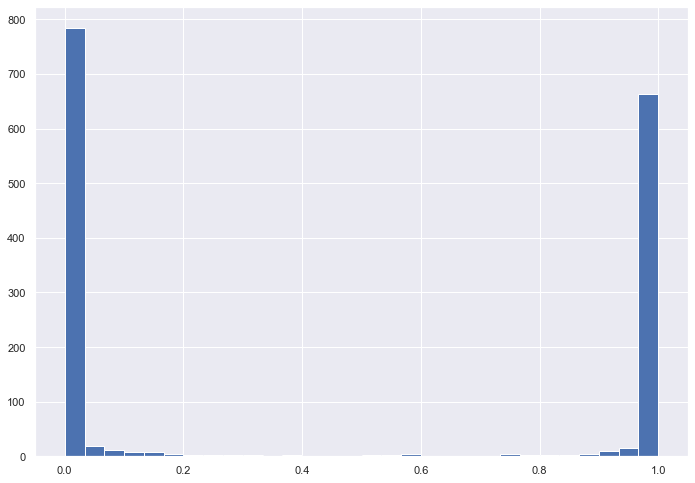

In [31]:
plt.hist(y_test_pred, bins=30)
plt.show()

In [32]:
roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)

(0.9999972182195492, 0.9973680003559875)

In [33]:
thr = 0.5
print(classification_report(y_test, y_test_pred > thr))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99       851
        True       0.98      0.99      0.99       713

    accuracy                           0.99      1564
   macro avg       0.99      0.99      0.99      1564
weighted avg       0.99      0.99      0.99      1564



### test on private samples in train

* by eye, they are clearly wiggly, so expect high proba there

In [34]:
df_ER[df_ER.event_energy == 20]

,N_error_x,N_error_y,N_x,N_y,bkgr_count_x,bkgr_count_y,chi2_pvalue_x,chi2_pvalue_y,chi2_x,chi2_y,...,sig_density_x,sig_density_y,sigma_error_x,sigma_error_y,sigma_x,sigma_y,tolerance_x,tolerance_y,up_x,up_y
88,1208.377341,1208.416193,1.460170e+06,1.460270e+06,1.447035e+06,1.447318e+06,0.338880,1.0,120.729957,19.310112,...,1477.035986,2075.146640,0.615383,0.396593,8.892997,6.241519,0.1,0.1,1.0,1.0
1935,1206.541136,1206.582449,1.455741e+06,1.455841e+06,1.444382e+06,1.445163e+06,0.495851,1.0,114.491282,14.815471,...,1298.786609,2046.491427,0.671088,0.366537,8.746008,5.217660,0.1,0.1,1.0,1.0


In [35]:
gbm.predict(df.query('event_energy == 20 and event_class == "ER"')[wiggly_vars])

array([0.99828706, 0.98410522])

### test it on public

In [36]:
y_public_pred = gbm.predict(df_public[wiggly_vars])
y_private_pred = gbm.predict(df_private[wiggly_vars])

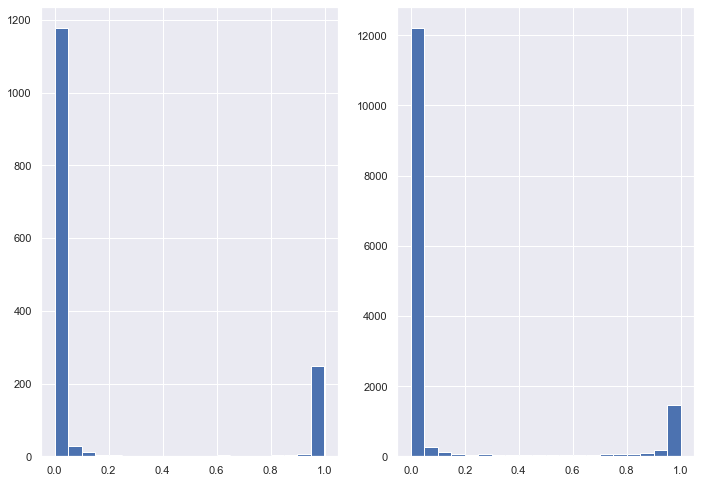

In [37]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(y_public_pred, bins=20)
axs[1].hist(y_private_pred, bins=20)
plt.show()

In [38]:
sum(y_public_pred > 0.5), sum(y_private_pred > 0.3)

(272, 2286)

* maybe by hand put negative sum counts somewhere? 

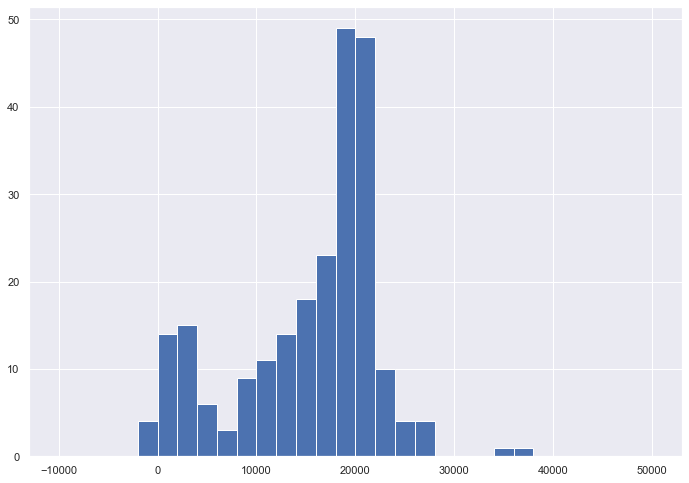

In [39]:
plt.hist(df_public[y_public_pred > 0.9].sig_count_y, bins=30, range=(-10000, 50000))
plt.show()

In [40]:
thr = 0.5

In [41]:
public_wiggly_pred = df_public.image_name[y_public_pred > thr].values
private_wiggly_pred = df_private.image_name[y_private_pred > thr].values

In [42]:
with open(f'wiggly_public_{thr}.txt', 'w') as f:
    f.write('\n'.join(public_wiggly_pred))

In [43]:
with open(f'wiggly_private_{thr}.txt', 'w') as f:
    f.write('\n'.join(private_wiggly_pred))

### interpret

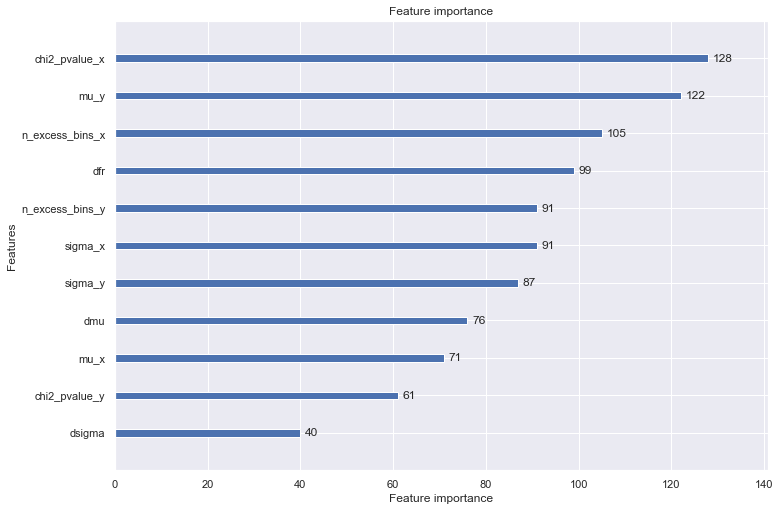

In [44]:
lgb.plot_importance(gbm)
plt.show()

In [45]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


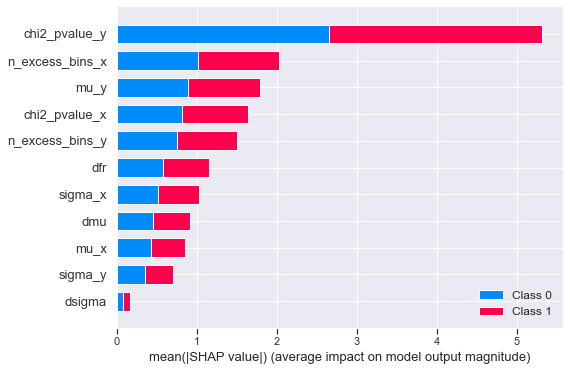

In [46]:
shap.summary_plot(shap_values, X)

### regressor

#### sig_count studies

In [47]:
# is sig_count resolution the same for diff. E?

In [48]:
sc_3_y = df.query('event_energy == 3').sig_count_y
sc_6_y = df.query('event_energy == 6').sig_count_y
sc_10_y = df.query('event_energy == 10').sig_count_y
sc_20_y = df.query('event_energy == 20').sig_count_y
#
sc_3_x = df.query('event_energy == 3').sig_count_x
sc_6_x = df.query('event_energy == 6').sig_count_x
sc_10_x = df.query('event_energy == 10').sig_count_x
sc_20_x = df.query('event_energy == 20').sig_count_x

In [49]:
sc_means = [np.mean(sc_3_y), np.mean(sc_6_y), np.mean(sc_10_y), np.mean(sc_20_y)]
sc_stds = [np.std(sc_3_y), np.std(sc_6_y), np.std(sc_10_y), np.std(sc_20_y)]
sc_energies = [3, 6, 10, 20]

In [50]:
sc_3_y -= np.mean(sc_3_y)
sc_6_y -= np.mean(sc_6_y)
sc_10_y -= np.mean(sc_10_y)
sc_20_y -= np.mean(sc_20_y)
#
sc_3_x -= np.mean(sc_3_x)
sc_6_x -= np.mean(sc_6_x)
sc_10_x -= np.mean(sc_10_x)
sc_20_x -= np.mean(sc_20_x)

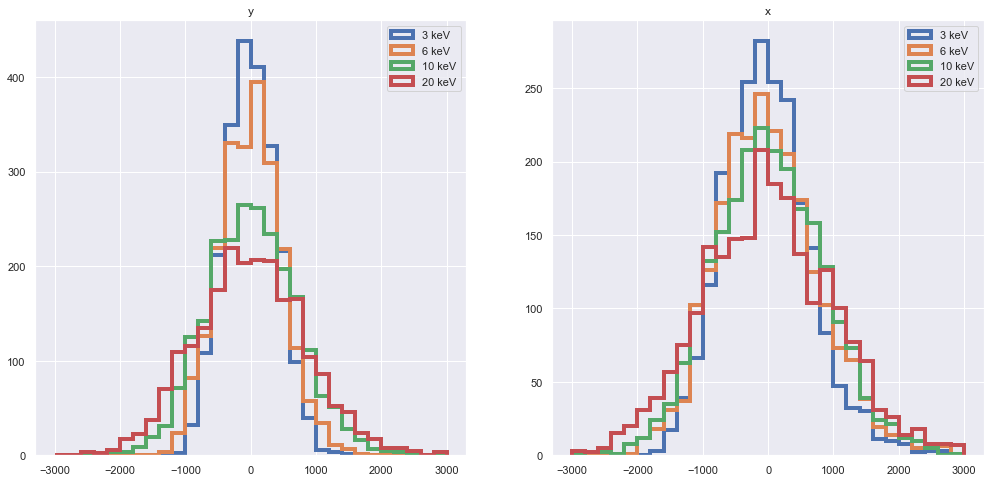

In [51]:
fig, axs = plt.subplots(1,2, figsize=(17,8))
axs[0].hist(sc_3_y, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='3 keV')
axs[0].hist(sc_6_y, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='6 keV')
axs[0].hist(sc_10_y, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='10 keV')
axs[0].hist(sc_20_y, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='20 keV')
axs[0].set_title('y')
axs[0].legend()
#
axs[1].hist(sc_3_x, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='3 keV')
axs[1].hist(sc_6_x, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='6 keV')
axs[1].hist(sc_10_x, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='10 keV')
axs[1].hist(sc_20_x, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='20 keV')
axs[1].set_title('x')
axs[1].legend()
plt.show()

#### extrapolate mean and std

In [52]:
a_mean, b_mean = np.polyfit(sc_energies, sc_means, deg=1)
a_std, b_std = np.polyfit(sc_energies, sc_stds, deg=1)

In [53]:
mean_30, std_30 = a_mean*30+b_mean, a_std*30+b_std, 
mean_30, std_30 

(16017.213016092774, 1145.5906357630997)

In [54]:
# generate synthetic data
sc_30_synth = np.random.normal(loc=mean_30, scale=std_30, size=2000)

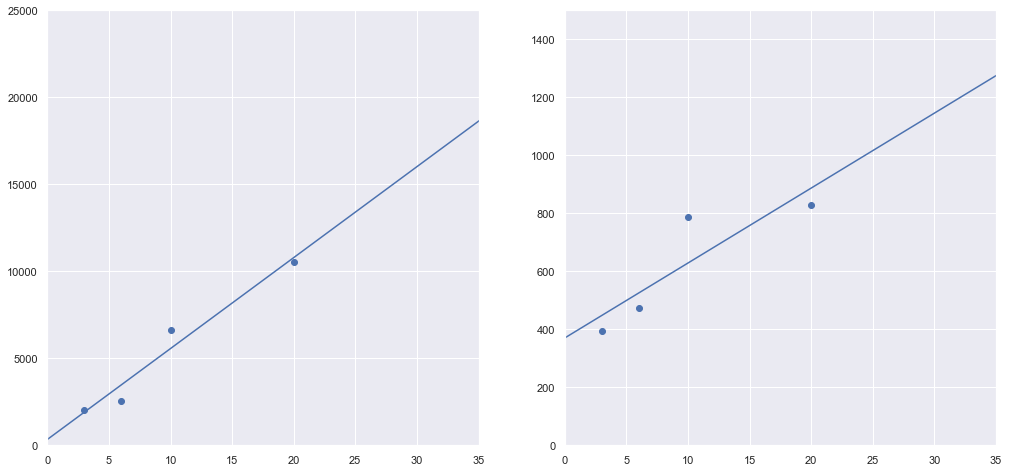

In [55]:
fig, axs = plt.subplots(1,2, figsize=(17,8))
axs[0].scatter(sc_energies, sc_means)
axs[0].plot([0, 40], a_mean*np.array([0, 40])+b_mean)
axs[1].scatter(sc_energies, sc_stds)
axs[1].plot([0, 40], a_std*np.array([0, 40])+b_std)
axs[0].set_xlim(0, 35)
axs[1].set_xlim(0, 35)
axs[0].set_ylim(0, 25000)
axs[1].set_ylim(0, 1500)
plt.show()

#### fit inclusively 

In [56]:
X = df.query('event_energy > 1 and event_energy < 30').sig_count_y
y = df.query('event_energy > 1 and event_energy < 30').event_energy

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# X_train = X_train.values.reshape(-1, 1)
# X_test = X_test.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [58]:
regr = SGDRegressor(loss='squared_loss', penalty='l2', alpha=.01, 
                    max_iter=1000, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)

In [59]:
# regr.fit(X_train, y_train)
regr.fit(y_train, X_train)

SGDRegressor(alpha=0.01, early_stopping=True, n_iter_no_change=10)

(array([735., 741.,   0.,   0., 754.,   0.,   0.,   0.,   0., 736.]),
 array([ 1853.97649729,  2723.07540769,  3592.17431809,  4461.27322849,
         5330.37213889,  6199.47104929,  7068.56995969,  7937.66887009,
         8806.76778049,  9675.86669089, 10544.96560129]),
 <BarContainer object of 10 artists>)

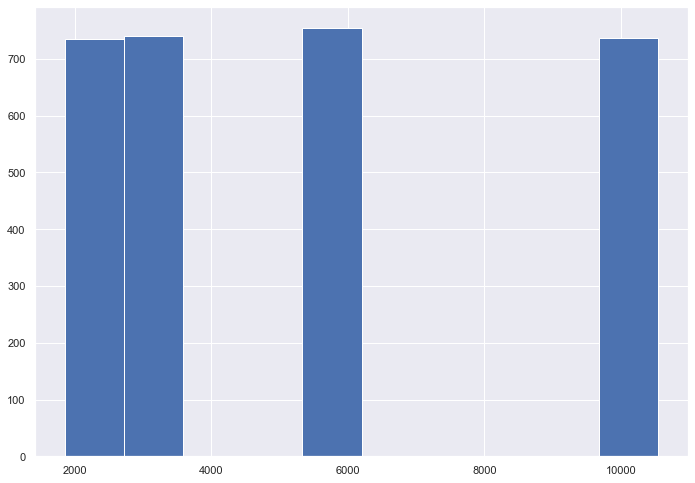

In [60]:
plt.hist(regr.predict(y_test))

In [61]:
regr.coef_, regr.intercept_

(array([511.23465318]), array([320.27253776]))

sc = coef_*E + intercept_   
E = (sc - intercept_)/coef_

In [62]:
def invert_regr(regr, y):
    x = (y - regr.intercept_)/regr.coef_
    return x

In [63]:
sc = df.query('event_energy < 30').sig_count_y
E_true = df.query('event_energy < 30').event_energy

In [64]:
E_pred = invert_regr(regr, sc)
E_pred_30_synth = invert_regr(regr, sc_30_synth)

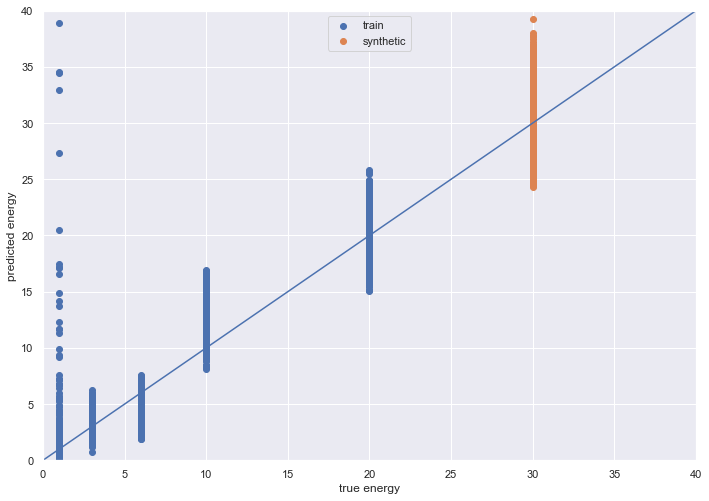

In [65]:
xmin, xmax = 0, 40
plt.scatter(E_true, E_pred, label='train')
plt.scatter(30*np.ones_like(E_pred_30_synth), E_pred_30_synth, label='synthetic')
plt.plot([xmin,xmax], [xmin,xmax])
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel('true energy')
plt.ylabel('predicted energy')
plt.legend(loc='upper center')
plt.show()

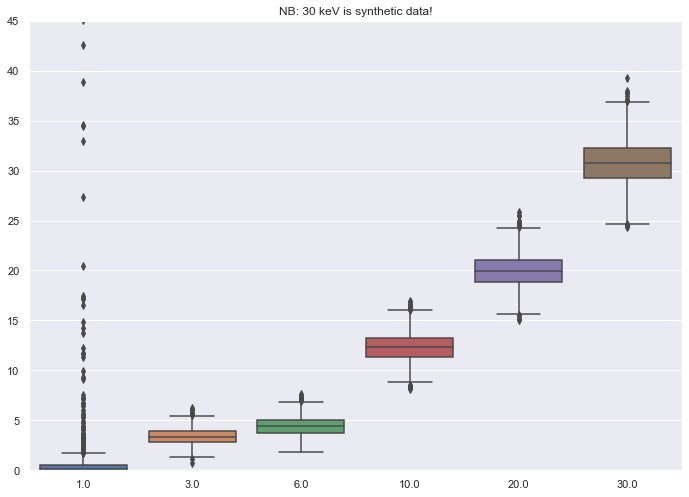

In [66]:
plt.ylim(0, 45)
plt.title("NB: 30 keV is synthetic data!")
sns.boxplot(x=np.concatenate([E_true, 30*np.ones_like(E_pred_30_synth),]), y=np.concatenate([E_pred, E_pred_30_synth]))
plt.show()

#### fit exclusively for ER/NR

In [67]:
X_ER = df.query('event_energy > 1 and event_energy < 30 and event_class == "ER"').sig_count_y
y_ER = df.query('event_energy > 1 and event_energy < 30 and event_class == "ER"').event_energy

X_NR = df.query('event_energy > 1 and event_energy < 30 and event_class == "NR"').sig_count_y
y_NR = df.query('event_energy > 1 and event_energy < 30 and event_class == "NR"').event_energy

In [68]:
X_ER_train, X_ER_test, y_ER_train, y_ER_test = train_test_split(X_ER, y_ER, test_size=0.33, random_state=42)
X_NR_train, X_NR_test, y_NR_train, y_NR_test = train_test_split(X_NR, y_NR, test_size=0.33, random_state=42)
#
y_ER_train = y_ER_train.values.reshape(-1, 1)
y_ER_test = y_ER_test.values.reshape(-1, 1)
y_NR_train = y_NR_train.values.reshape(-1, 1)
y_NR_test = y_NR_test.values.reshape(-1, 1)

In [69]:
regr_ER = SGDRegressor(loss='squared_loss', penalty='l2', alpha=.01, 
                    max_iter=1000, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)
regr_NR = SGDRegressor(loss='squared_loss', penalty='l2', alpha=.01, 
                    max_iter=1000, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)

In [70]:
regr_ER.fit(y_ER_train, X_ER_train)
regr_NR.fit(y_NR_train, X_NR_train)

SGDRegressor(alpha=0.01, early_stopping=True, n_iter_no_change=10)

In [71]:
regr_ER.coef_, regr_ER.intercept_

(array([618.71806702]), array([93.21810388]))

In [72]:
regr_NR.coef_, regr_NR.intercept_

(array([563.40721903]), array([-857.7607644]))

In [73]:
regr_ER.predict([[1], [6]]) # expect in test

array([ 711.9361709 , 3805.52650598])

In [74]:
regr_NR.predict([[3], [10]]) # expect in test

array([ 832.4608927 , 4776.31142591])

sc = coef_*E + intercept_   
E = (sc - intercept_)/coef_

In [75]:
sc = df.query('event_energy < 30').sig_count_y
E_true = df.query('event_energy < 30').event_energy

In [76]:
E_pred = invert_regr(regr, sc)
E_pred_30_synth = invert_regr(regr, sc_30_synth)

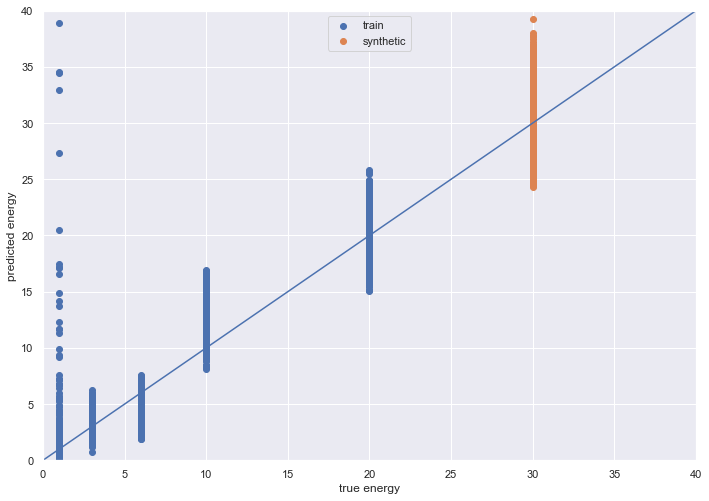

In [77]:
xmin, xmax = 0, 40
plt.scatter(E_true, E_pred, label='train')
plt.scatter(30*np.ones_like(E_pred_30_synth), E_pred_30_synth, label='synthetic')
plt.plot([xmin,xmax], [xmin,xmax])
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel('true energy')
plt.ylabel('predicted energy')
plt.legend(loc='upper center')
plt.show()

### hacking private

In [78]:
sc_private = df_private.sig_count_y
E_pred_private = invert_regr(regr, sc_private)
min(E_pred_private), max(E_pred_private)

(-59.65739206682759, 977.6456565281616)

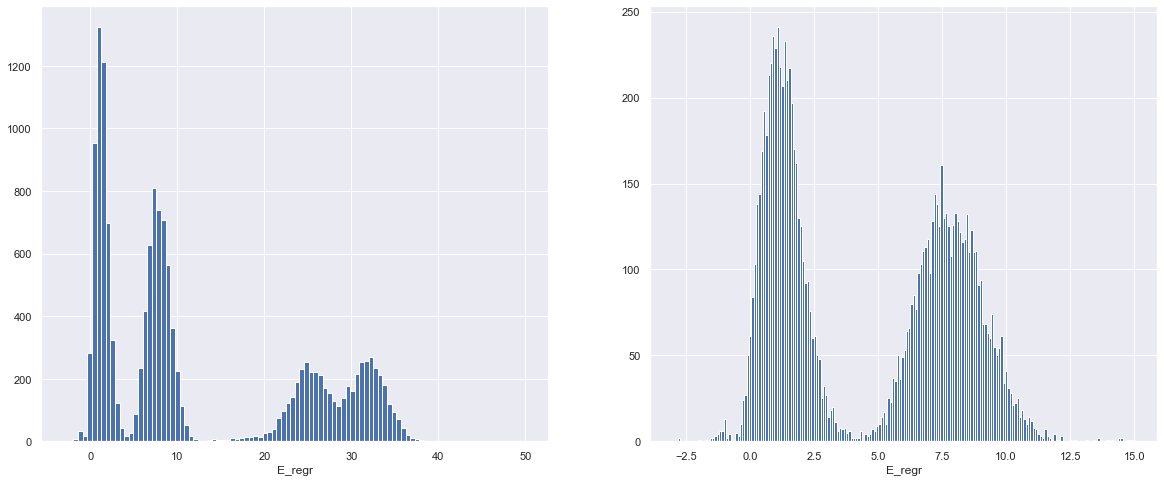

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].hist(E_pred_private, bins=100, range=(-3, 50))
axs[0].set_xlabel('E_regr')
axs[1].hist(E_pred_private, bins=200, range=(-3, 15))
axs[1].set_xlabel('E_regr')
plt.show()

In [80]:
sum(~((E_pred_private > 0) & (E_pred_private < 50))), E_pred_private.shape

(220, (15061,))

In [81]:
sum(((E_pred_private > 4) & (E_pred_private < 12)))

5000

In [82]:
sum(E_pred_private < 4)

5039

In [83]:
sum((E_pred_private > 26) & (E_pred_private < 40))

3294

In [84]:
sum(E_pred_private < 0)

209

#### remove wiggly

In [85]:
y_private_pred = gbm.predict(df_private[wiggly_vars])

In [86]:
thr = 0.05
sc_private_nw = df_private[y_private_pred<thr].sig_count_y
sc_private_w = df_private[y_private_pred>=thr].sig_count_y
E_pred_private_nw = invert_regr(regr, sc_private_nw)
E_pred_private_w = invert_regr(regr, sc_private_w)
min(E_pred_private_nw), max(E_pred_private_nw)

(-4.796772441136632, 38.45373001985319)

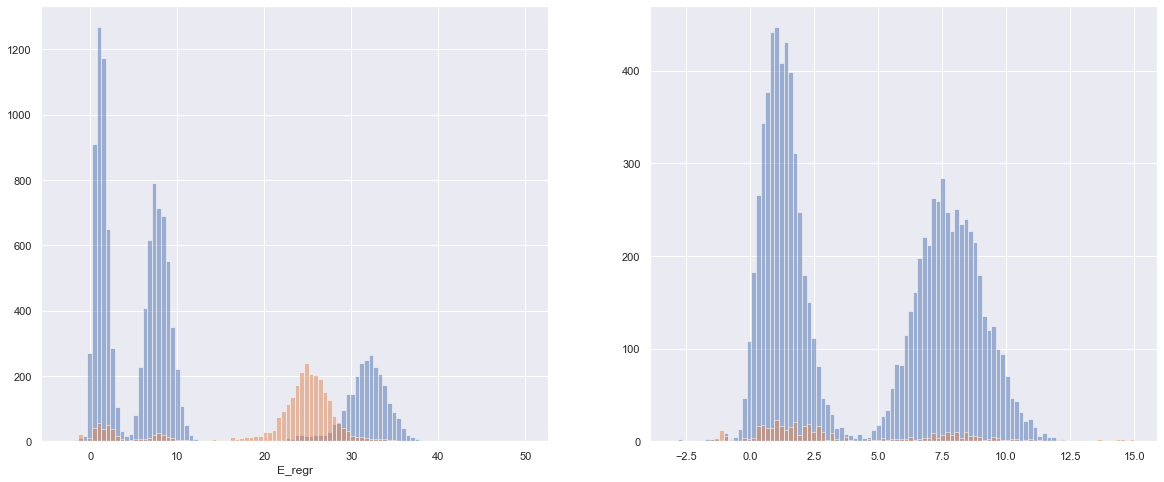

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].hist(E_pred_private_nw, bins=100, range=(-3, 50), alpha=0.5)
axs[0].hist(E_pred_private_w, bins=100, range=(-3, 50), alpha=0.5)
axs[0].set_xlabel('E_regr')
axs[1].hist(E_pred_private_nw, bins=100, range=(-3, 15), alpha=0.5)
axs[1].hist(E_pred_private_w, bins=100, range=(-3, 15), alpha=0.5)
axs[0].set_xlabel('E_regr')
plt.show()

In [88]:
sum(y_private_pred > 0.05)

2859

### domain difference

In [89]:
sc_train_1_3 = df.query('event_energy>=1 and event_energy<=3').sig_count_y
sc_train_6_10 = df.query('event_energy>=6 and event_energy<=10').sig_count_y
sc_train_20_30 = df.query('event_energy>=20 and event_energy<=30').sig_count_y
E_pred_train_1_3 = invert_regr(regr, sc_train_1_3)
E_pred_train_6_10 = invert_regr(regr, sc_train_6_10)
E_pred_train_20_30 = invert_regr(regr, sc_train_20_30)
E_pred_public = invert_regr(regr, df_public.sig_count_y)
E_pred_private = invert_regr(regr, df_private.sig_count_y)
min(E_pred_train_1_3), max(E_pred_train_1_3)

(-441.2405777451832, 263.81297466823696)

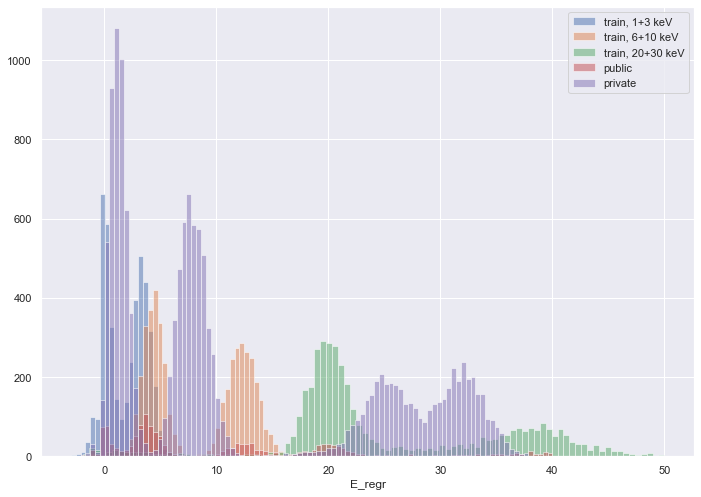

In [90]:
# fig, axs = plt.subplots(1, 2, figsize=(20,8))
plt.hist(E_pred_train_1_3, bins=100, range=(-3, 40), alpha=0.5, label='train, 1+3 keV')
plt.hist(E_pred_train_6_10, bins=100, range=(-3, 40), alpha=0.5, label='train, 6+10 keV')
plt.hist(E_pred_train_20_30, bins=100, range=(-3, 50), alpha=0.5, label='train, 20+30 keV')
plt.hist(E_pred_public, bins=100, range=(-3, 40), alpha=0.5, label='public')
plt.hist(E_pred_private, bins=100, range=(-3, 40), alpha=0.5, label='private')
plt.xlabel('E_regr')
# axs[1].hist(E_pred_private_nw, bins=100, range=(-3, 20), alpha=0.5)
plt.legend()
plt.show()

#### predict on test domain in train

In [91]:
df.query('event_energy == 6 and event_class == "ER"')

,N_error_x,N_error_y,N_x,N_y,bkgr_count_x,bkgr_count_y,chi2_pvalue_x,chi2_pvalue_y,chi2_x,chi2_y,...,sigma_error_x,sigma_error_y,sigma_x,sigma_y,tolerance_x,tolerance_y,up_x,up_y,sig_count_x_over_E,sig_count_y_over_E
2950,1204.317146,1204.363644,1.450380e+06,1.450492e+06,1.445151e+06,1.446360e+06,0.262632,1.0,124.206241,12.223563,...,0.857808,0.742359,5.614171,4.526541,0.1,0.1,1.0,1.0,871.449758,688.616644


In [92]:
invert_regr(regr, df.query('event_energy == 6 and event_class == "ER"').sig_count_y)

2950    7.455338
Name: sig_count_y, dtype: float64

In [93]:
invert_regr(regr, df.query('event_energy == 10 and event_class == "NR"').sig_count_y)

1559    8.125035
4747    8.479083
Name: sig_count_y, dtype: float64

In [94]:
invert_regr(regr, df.query('event_energy == 3 and event_class == "NR"').sig_count_y)

960     1.772658
2891    2.626965
Name: sig_count_y, dtype: float64

In [95]:
invert_regr(regr, df.query('event_energy == 1 and event_class == "ER"').sig_count_y)

359     0.709306
3691    4.379928
4162    0.076103
Name: sig_count_y, dtype: float64

### separate 6 vs 10 

In [9]:
df.columns

Index(['N_error_x', 'N_error_y', 'N_x', 'N_y', 'bkgr_count_x', 'bkgr_count_y',
       'chi2_pvalue_x', 'chi2_pvalue_y', 'chi2_x', 'chi2_y', 'dfr', 'dmu',
       'dsigma', 'edm_x', 'edm_y', 'event_ID', 'event_angle', 'event_class',
       'event_energy', 'fr_error_x', 'fr_error_y', 'fr_x', 'fr_y', 'fval_x',
       'fval_y', 'has_accurate_covar_x', 'has_accurate_covar_y',
       'has_covariance_x', 'has_covariance_y', 'has_made_posdef_covar_x',
       'has_made_posdef_covar_y', 'has_parameters_at_limit_x',
       'has_parameters_at_limit_y', 'has_posdef_covar_x', 'has_posdef_covar_y',
       'has_reached_call_limit_x', 'has_reached_call_limit_y',
       'has_valid_parameters_x', 'has_valid_parameters_y', 'hesse_failed_x',
       'hesse_failed_y', 'image_name', 'is_above_max_edm_x',
       'is_above_max_edm_y', 'is_valid_x', 'is_valid_y', 'mu_error_x',
       'mu_error_y', 'mu_x', 'mu_y', 'n_excess_bins_x', 'n_excess_bins_y',
       'nfcn_total_x', 'nfcn_total_y', 'nfcn_x', 'nfcn_y', 'ngr

In [10]:
clf_vars = [
#               'chi2_pvalue_x', 'chi2_pvalue_y', 
#                'chi2_x', 'chi2_y',
              'dfr', 
              'dmu', 'dsigma', 
#               'fr_error_x', 'fr_error_y', 'fr_x', 'fr_y',
              'sigma_x', 'sigma_y', 
#               'sigma_error_x', 'sigma_error_y', 
              'mu_x', 'mu_y', 
#               'mu_error_x', 'mu_error_y', 
              'n_excess_bins_x', 'n_excess_bins_y', 
#                'nfcn_total_x', 'nfcn_total_y',
#        'nfcn_x', 'nfcn_y', 'ngrad_total_x', 'ngrad_total_y', 'ngrad_x', 'ngrad_y', 
              'sig_count_x', 'sig_count_y', 
              'sig_density_x', 'sig_density_y', 
#                'dsig_count'
              ]

In [41]:
# df_1 = df[df['event_energy'] == 1][:500]
# df_3 = df[df['event_energy'] == 3][:500]
df_6 = df[df['event_energy'] == 6]
df_10 = df[df['event_energy'] == 10]
# df_20 = df[df['event_energy'] == 20][:500]
# df_30 = df[df['event_energy'] == 30]
df_6_vs_10 = pd.concat([df_6, df_10])

df_6_vs_10.sort_values('image_name', inplace=True)

In [42]:
# df_w_vs_all['sig_count_y_gr_8500'] = df_w_vs_all.sig_count_y > 8500
# df_public['sig_count_y_gr_8500'] = df_public.sig_count_y > 8500
# df_private['sig_count_y_gr_8500'] = df_private.sig_count_y > 8500

In [43]:
np.unique(df_6_vs_10.event_energy, return_counts=1)

(array([ 6, 10]), array([2256, 2274]))

In [44]:
X = df_6_vs_10[clf_vars]
y = df_6_vs_10['event_energy'] == 10
np.bincount(y)

array([2256, 2274])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [46]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [47]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'early_stopping_rounds': 10
}

In [48]:
clf = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                verbose_eval=True,
#                 feature_name=X_train.columns,
#                 categorical_feature=[21]
               )

[1]	valid_0's binary_logloss: 0.598808
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.521481
[3]	valid_0's binary_logloss: 0.457018
[4]	valid_0's binary_logloss: 0.402519
[5]	valid_0's binary_logloss: 0.355994
[6]	valid_0's binary_logloss: 0.31621
[7]	valid_0's binary_logloss: 0.281636
[8]	valid_0's binary_logloss: 0.251284
[9]	valid_0's binary_logloss: 0.224705
[10]	valid_0's binary_logloss: 0.201265
[11]	valid_0's binary_logloss: 0.180626
[12]	valid_0's binary_logloss: 0.162348
[13]	valid_0's binary_logloss: 0.146104
[14]	valid_0's binary_logloss: 0.131656
[15]	valid_0's binary_logloss: 0.118772
[16]	valid_0's binary_logloss: 0.107521
[17]	valid_0's binary_logloss: 0.0972368
[18]	valid_0's binary_logloss: 0.0880526
[19]	valid_0's binary_logloss: 0.0799106
[20]	valid_0's binary_logloss: 0.072577
[21]	valid_0's binary_logloss: 0.0660644
[22]	valid_0's binary_logloss: 0.060131
[23]	valid_0's binary_logloss: 0.0549055
[24]	valid_0's binary_lo

Found `early_stopping_rounds` in params. Will use it instead of argument


In [49]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

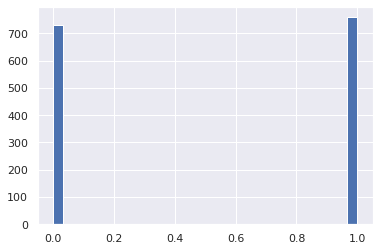

In [50]:
plt.hist(y_test_pred, bins=30)
plt.show()

In [51]:
roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)

(1.0, 0.999994628911495)

In [52]:
thr = 0.5
print(classification_report(y_test, y_test_pred > thr))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       733
        True       1.00      1.00      1.00       762

    accuracy                           1.00      1495
   macro avg       1.00      1.00      1.00      1495
weighted avg       1.00      1.00      1.00      1495



In [53]:
df.query('event_energy == 6 and event_class == "ER"')

,N_error_x,N_error_y,N_x,N_y,bkgr_count_x,bkgr_count_y,chi2_pvalue_x,chi2_pvalue_y,chi2_x,chi2_y,...,sigma_error_x,sigma_error_y,sigma_x,sigma_y,tolerance_x,tolerance_y,up_x,up_y,sig_count_x_over_E,sig_count_y_over_E
2950,1204.317146,1204.363644,1.450380e+06,1.450492e+06,1.445151e+06,1.446360e+06,0.262632,1.0,124.206241,12.223563,...,0.857808,0.742359,5.614171,4.526541,0.1,0.1,1.0,1.0,871.449758,688.616644


In [54]:
clf.predict(df.query('event_energy == 6 and event_class == "ER"')[clf_vars])

array([0.8433944])

In [55]:
clf.predict(df.query('event_energy == 10 and event_class == "NR"')[clf_vars])

array([0.06160818, 0.96683033])

In [39]:
X_train.index

Int64Index([2353, 1664,  655, 4972, 2923, 3299,  631, 1061, 6268, 6309,
            ...
            4905,  397, 1949, 2723, 3493, 6489, 1328, 2487, 4475, 2437],
           dtype='int64', length=3035)

In [38]:
df.query('event_energy == 10 and event_class == "NR"')['image_name']

1559    -0.9444000124931335__CYGNO_60_40_He_NR_10_keV_...
4747    2.4159998893737793__CYGNO_60_40_He_NR_10_keV_9...
Name: image_name, dtype: object

In [30]:
df.query('event_energy == 10 and event_class == "NR"')[clf_vars]

,dfr,dmu,dsigma,sigma_x,sigma_y,mu_x,mu_y,n_excess_bins_x,n_excess_bins_y,sig_count_x,sig_count_y,sig_density_x,sig_density_y
1559,0.000325,1.640990,0.257050,5.799134,5.542084,289.311151,287.670160,70.0,72.0,4945.396063,4474.071746,852.781837,807.290444
4747,-0.000517,-0.737608,-1.797976,4.516990,6.314966,287.439026,288.176635,74.0,69.0,3904.511020,4655.073580,864.405486,737.149408


In [112]:
y_public_pred_clf = clf.predict(df_public[clf_vars])
y_private_pred_clf = clf.predict(df_private[clf_vars])

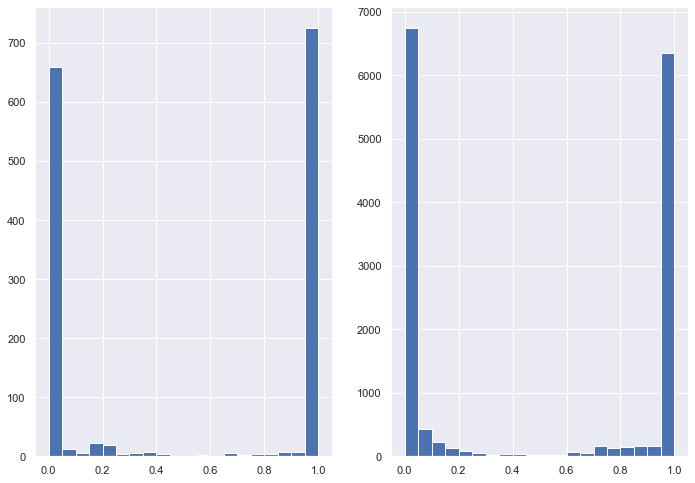

In [113]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(y_public_pred_clf, bins=20)
axs[1].hist(y_private_pred_clf, bins=20)
plt.show()

In [114]:
sum(y_public_pred_clf > 0.5), sum(y_private_pred_clf > 0.5)

(760, 7266)

In [115]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


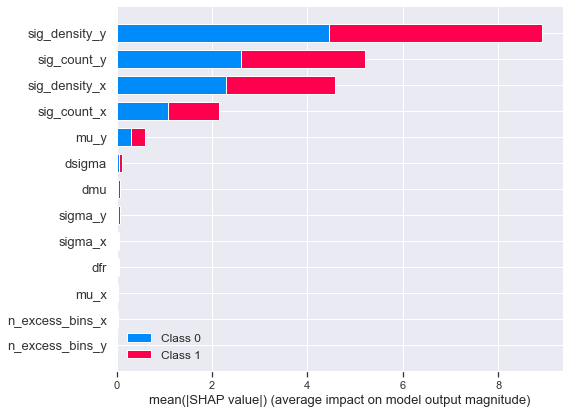

In [116]:
shap.summary_plot(shap_values, X)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

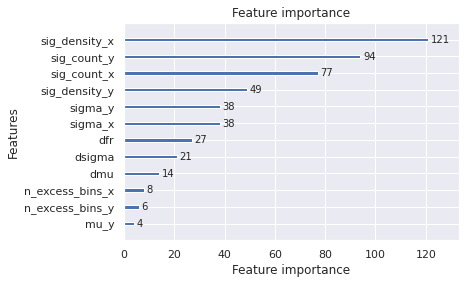

In [58]:
lgb.plot_importance(clf)

In [117]:
thr = 0.05
thr_clf = 0.5
sc_private_nw_6 = df_private[(y_private_pred<thr) & (y_private_pred_clf<thr_clf)].sig_count_y
sc_private_nw_10 = df_private[(y_private_pred<thr) & (y_private_pred_clf>=thr_clf)].sig_count_y
sc_private_w = df_private[y_private_pred>=thr].sig_count_y
E_pred_private_nw_6 = invert_regr(regr, sc_private_nw_6)
E_pred_private_nw_10 = invert_regr(regr, sc_private_nw_10)
E_pred_private_w = invert_regr(regr, sc_private_w)
min(E_pred_private_nw), max(E_pred_private_nw)

(-4.796772441136632, 38.45373001985319)

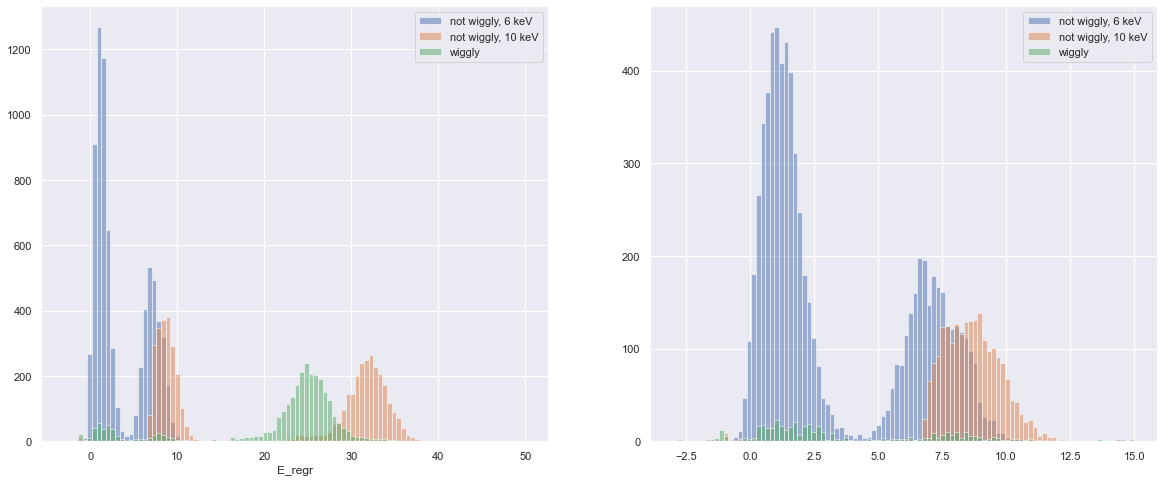

In [118]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].hist(E_pred_private_nw_6, bins=100, range=(-3, 50), alpha=0.5, label='not wiggly, 6 keV')
axs[0].hist(E_pred_private_nw_10, bins=100, range=(-3, 50), alpha=0.5, label='not wiggly, 10 keV')
axs[0].hist(E_pred_private_w, bins=100, range=(-3, 50), alpha=0.5, label='wiggly')
axs[0].set_xlabel('E_regr')
axs[0].legend()
axs[1].hist(E_pred_private_nw_6, bins=100, range=(-3, 15), alpha=0.5, label='not wiggly, 6 keV')
axs[1].hist(E_pred_private_nw_10, bins=100, range=(-3, 15), alpha=0.5, label='not wiggly, 10 keV')
axs[1].hist(E_pred_private_w, bins=100, range=(-3, 15), alpha=0.5, label='wiggly')
axs[0].set_xlabel('E_regr')
axs[1].legend()
plt.show()

In [119]:
sum(E_pred_private_nw_10 < 15)

2172

### dev

<AxesSubplot:xlabel='sig_density_y', ylabel='Count'>

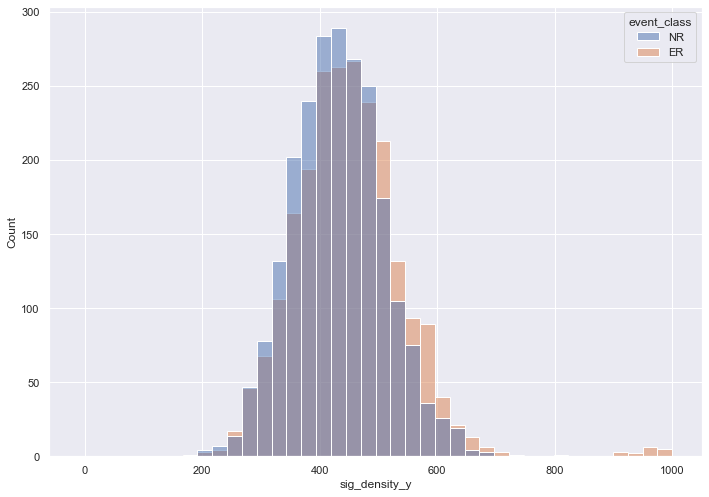

In [120]:
sns.histplot(x='sig_density_y', data=df.query('event_energy > 1 and event_energy < 30'), hue='event_class', bins=40, binrange=(-10, 1000))

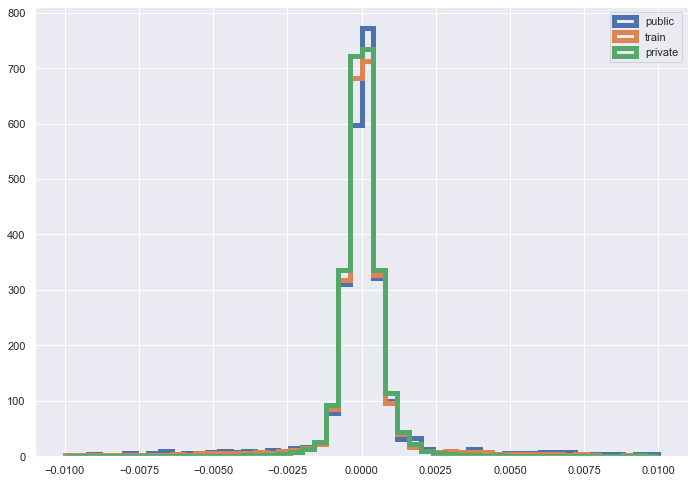

In [121]:
plt.hist(df_public.dfr, bins=50, range=(-.01, 0.01), linewidth=5, density=True, histtype='step', label='public')
plt.hist(df.dfr, bins=50, range=(-.01, 0.01), linewidth=5, density=True, histtype='step', label='train')
plt.hist(df_private.dfr, bins=50, range=(-.01, 0.01), linewidth=5, density=True, histtype='step', label='private')
plt.legend()
plt.show()